# Idea to improve motion network accuracy

Essentially I've done two things I've used a simple CIFAR style network (i.e. small convolution network of the internet that scores over 90% on CIFAR) which gave me 25% accuracy. Then I attempted using VGG16 which is quite a powerful network but I fudged the input layer weights using a trick call network modality. 
In theory this mean fine scale structures are potentially going into further on layers looking like garbage. I still got some decent results. But the training was quite slow. 

I do feel perhaps I'm not being patient with the training. 10 classes is one thing (CIFAR), a 101 is another. And then 1000 classes is definitely something else. Learning more fine grained differences may simply take quite a long time of learnning. I'm considering a much longer amount of training to see how it evolves. 

In [1]:
import os
import sys


up1 = os.path.abspath('../utils/') 
up2 = os.path.abspath('../models/') 
sys.path.insert(0, up1)
sys.path.insert(0, up2)

In [2]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow
from motion_network import getKerasCifarMotionModel2, getKerasCifarMotionModelOnly
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from keras.optimizers import SGD
import cv2 
import numpy as np



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
from keras.callbacks import ModelCheckpoint, Callback

def get_callbacks(filepath):
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [msave]
file_path = "/data/su_buildup/two_stream_part2/data/weights/motion_model_weights_inv2.hdf5"
callbacks = get_callbacks(filepath=file_path)

In [4]:
motion_model=getKerasCifarMotionModel2((224,224,2), 101, dropout=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      608       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
__________

In [4]:
cifar_model = getKerasCifarMotionModelOnly((224,224,2), 101)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 32)      608       
_________________________________________________________________
activation_8 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
activation_9 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 111, 111, 64)      18496     
__________

## Number of Parameters?

Its interesting between both models there's a significant drop in parameters mostly because I the use of further downsampling with convolution nets and pooling

In [4]:
params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 32,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
           'validation' : False}

params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 32,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
           'validation' : True}

In [5]:
id_labels_train = get_train_data_opt_flow('../data/ucf101_splits/trainlist01.txt')
labels = id_labels_train[1]
id_test = get_test_data_opt_flow('../data/ucf101_splits/testlist01.txt', \
                       '../data/ucf101_splits/classInd.txt')

training_generator = DataGenerator(*id_labels_train, **params_train)


validation_generator = DataGenerator(id_test[0], id_test[1], **params_valid)

In [6]:
mypotim = SGD(lr=1e-3, momentum=0.9)
motion_model.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [7]:
mod1 = motion_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=2,
                    verbose=1)

Epoch 1/2
298/298 [==============================] - 132s 441ms/step - loss: 4.7310 - acc: 0.0361 - val_loss: 4.8861 - val_acc: 0.0339
Epoch 2/2
298/298 [==============================] - 128s 430ms/step - loss: 4.3781 - acc: 0.0628 - val_loss: 5.3158 - val_acc: 0.0395


In [10]:
motion_model_dropout=getKerasCifarMotionModel2((224,224,2), 101, dropout=1, printmod=0)

In [11]:
mypotim = SGD(lr=1e-3, momentum=0.9)
motion_model_dropout.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [12]:
mod1 = motion_model_dropout.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=2,
                    verbose=1)

Epoch 1/2
298/298 [==============================] - 134s 451ms/step - loss: 4.9439 - acc: 0.0100 - val_loss: 7.1359 - val_acc: 0.0119
Epoch 2/2
298/298 [==============================] - 132s 441ms/step - loss: 4.6518 - acc: 0.0101 - val_loss: 7.5863 - val_acc: 0.0183


    Its pretty clear cut that the excessive dropout  used by the motion_model_dropout causes a much slower learning rate. And  
    In theory one can expect that this model in the long term may converge with a higher accuracy. But can you wait  that long and is it worth it? Will you run out of money for the quicker model (with little or no dropout)

# Train for a long time 

In [10]:
mod1 = motion_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=20,
                    verbose=1, callbacks=callbacks)

Epoch 1/20
298/298 [==============================] - 128s 429ms/step - loss: 4.1239 - acc: 0.0905 - val_loss: 4.7750 - val_acc: 0.0646
Epoch 2/20
298/298 [==============================] - 128s 430ms/step - loss: 3.9554 - acc: 0.1156 - val_loss: 5.0097 - val_acc: 0.0699
Epoch 3/20
298/298 [==============================] - 128s 429ms/step - loss: 3.7775 - acc: 0.1463 - val_loss: 4.5488 - val_acc: 0.0853
Epoch 4/20
298/298 [==============================] - 128s 428ms/step - loss: 3.6650 - acc: 0.1681 - val_loss: 4.7954 - val_acc: 0.0813
Epoch 5/20
298/298 [==============================] - 128s 428ms/step - loss: 3.5230 - acc: 0.1913 - val_loss: 4.3767 - val_acc: 0.1107
Epoch 6/20
298/298 [==============================] - 128s 428ms/step - loss: 3.4437 - acc: 0.2095 - val_loss: 4.4349 - val_acc: 0.1012
Epoch 7/20
298/298 [==============================] - 128s 429ms/step - loss: 3.3205 - acc: 0.2297 - val_loss: 4.7302 - val_acc: 0.1017
Epoch 8/20
298/298 [============================

In [11]:
mod1 = motion_model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=20,
                    verbose=1, callbacks=callbacks)

Epoch 1/20
298/298 [==============================] - 128s 428ms/step - loss: 2.3417 - acc: 0.4324 - val_loss: 4.2712 - val_acc: 0.1907
Epoch 2/20
298/298 [==============================] - 127s 427ms/step - loss: 2.2981 - acc: 0.4493 - val_loss: 4.4075 - val_acc: 0.1703
Epoch 3/20
298/298 [==============================] - 128s 429ms/step - loss: 2.2359 - acc: 0.4606 - val_loss: 4.3477 - val_acc: 0.1679
Epoch 4/20
298/298 [==============================] - 128s 428ms/step - loss: 2.1892 - acc: 0.4711 - val_loss: 4.3525 - val_acc: 0.1854
Epoch 5/20
298/298 [==============================] - 128s 430ms/step - loss: 2.1702 - acc: 0.4781 - val_loss: 4.4145 - val_acc: 0.1806
Epoch 6/20
298/298 [==============================] - 128s 429ms/step - loss: 2.1175 - acc: 0.4820 - val_loss: 4.3148 - val_acc: 0.1901
Epoch 7/20
298/298 [==============================] - 128s 431ms/step - loss: 2.0711 - acc: 0.4962 - val_loss: 4.0698 - val_acc: 0.1981
Epoch 8/20
298/298 [============================

In [110]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


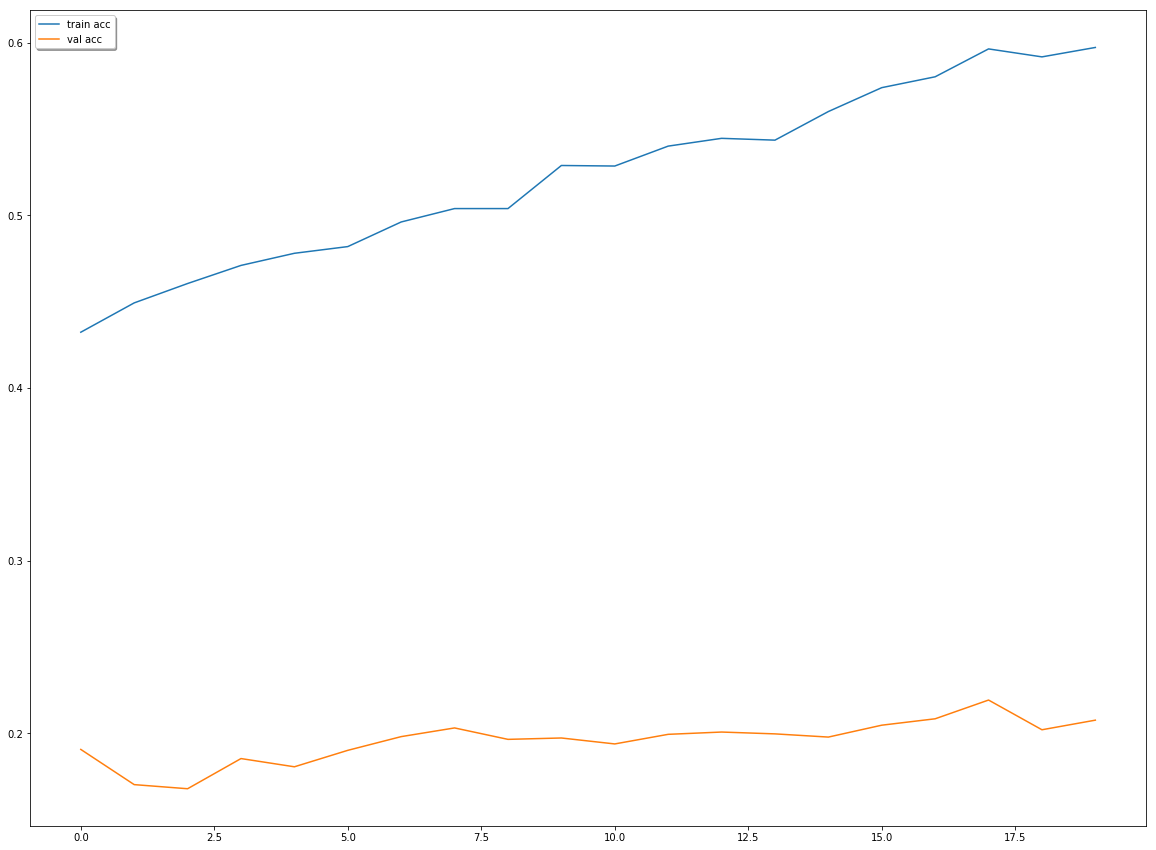

In [87]:

fig, ax = plt.subplots()
ax.plot(mod1.history['acc'], label='train acc')
ax.plot(mod1.history['val_acc'], label='val acc')
legend = ax.legend(loc='best', shadow=True)

You can see that the  train accuracy has far outpaced the validation accuracy which only means one thing.  Over fitting. The next question then is  what is it overfitting (i.e. getting wrong)? The best way to figure this out is probably a confusion matrix.

In [75]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [95]:
predict = np.empty((len(validation_generator)*32, 101), dtype=float)
labels = np.empty((len(validation_generator)*32, 101), dtype=int)
predict.shape

(3776, 101)

In [96]:

for i, (X, y) in enumerate(validation_generator):
    predict[i*32:(i+1)*32,] = motion_model.predict(X)
    labels[i*32:(i+1)*32] = y
    if i == len(validation_generator) - 1:
        break
    

In [97]:
predict.shape

(3776, 101)

In [98]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [99]:
rounded_predictions = predict.argmax(axis=1)

In [100]:
rounded_predictions 

array([31, 28, 24, ..., 99, 56, 84])

In [103]:
rounded_predictions.min()

0

In [101]:
rounded_labels = labels.argmax(axis=1)

In [104]:
rounded_labels.min()

0

In [105]:
from sklearn.metrics import confusion_matrix

In [112]:
cm = confusion_matrix(rounded_labels, rounded_predictions)

In [113]:
# plot labels
import csv 
with open('/data/su_buildup/two_stream_part2/data/ucf101_splits/classInd.txt', 'r') as f:
    reader = csv.reader(f)
    class_index= list(reader)
    

In [114]:
cm_plot_labels = [str(i) for i in range(1,102)]

Confusion matrix, without normalization
[[2 0 0 ... 0 4 1]
 [2 4 1 ... 2 1 0]
 [0 0 4 ... 1 0 0]
 ...
 [1 1 0 ... 5 4 0]
 [0 0 1 ... 0 8 0]
 [0 0 1 ... 1 0 2]]


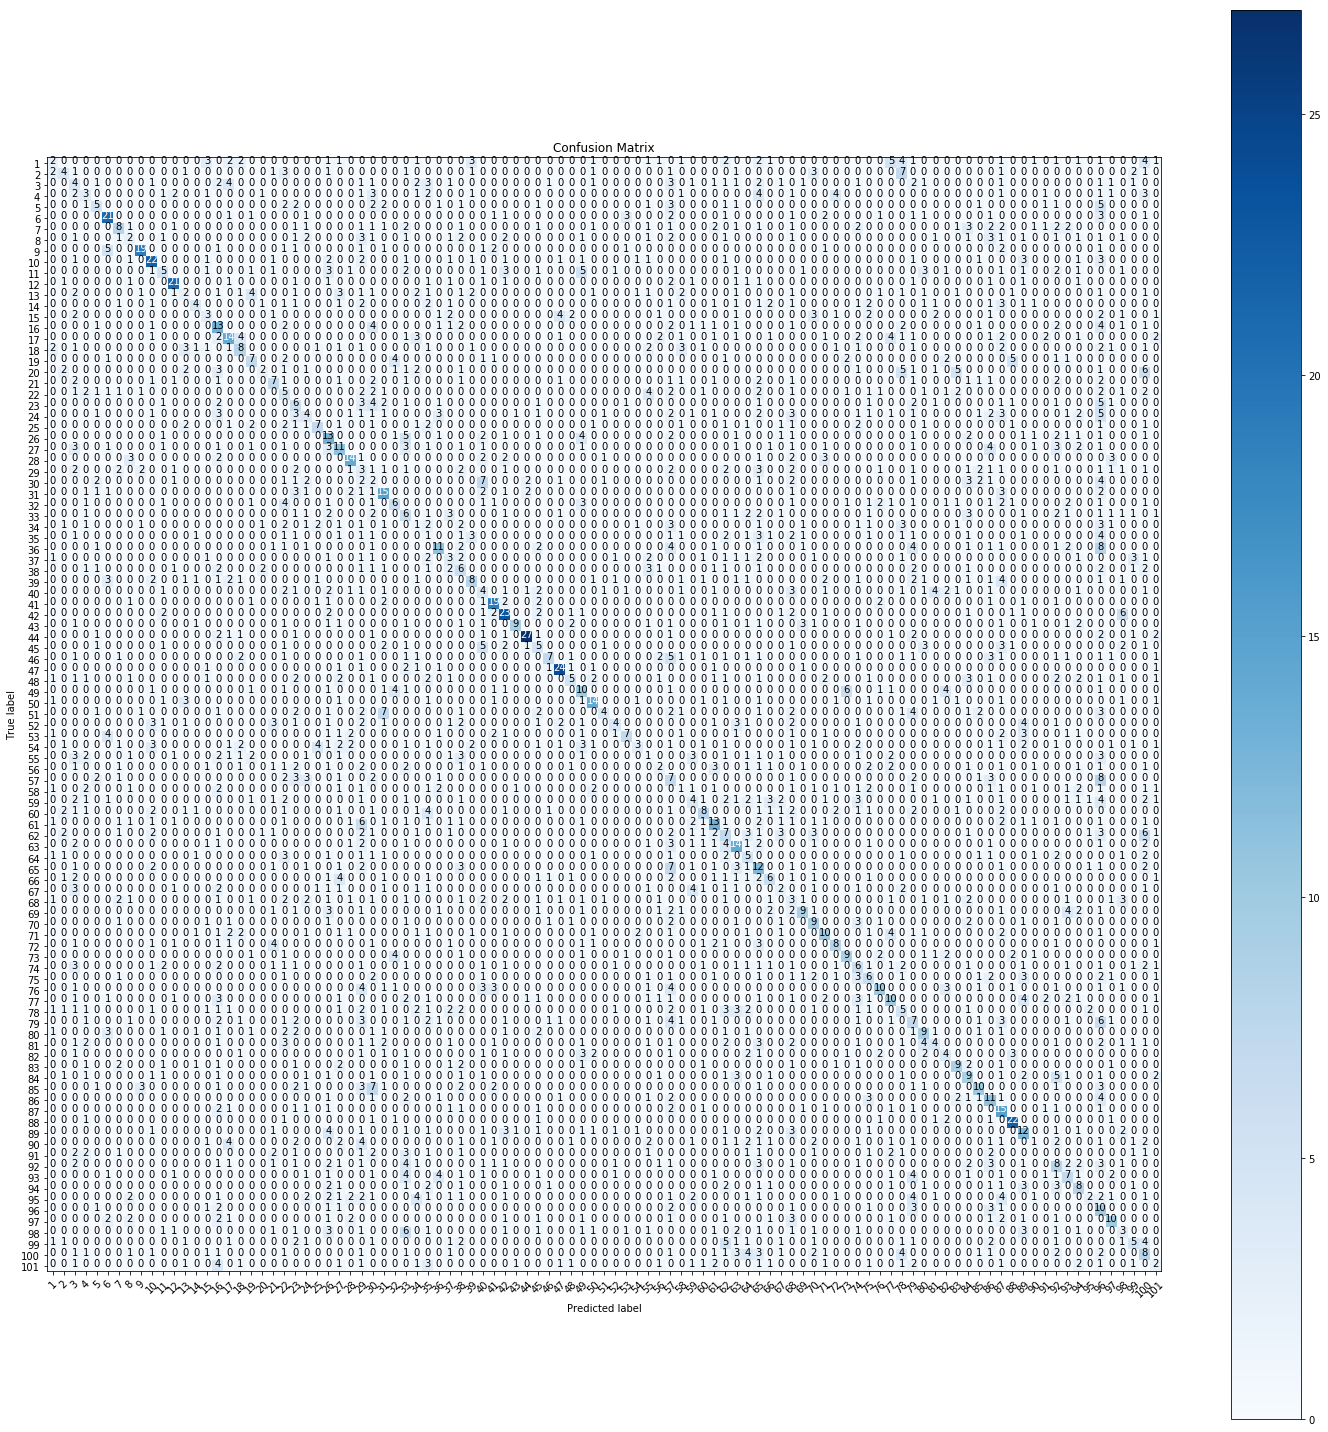

In [115]:
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

Well I can see definitely there is a lot of misclassification but the 20% accuracy  is already showing in the  bluish line, (lets say 10 average value on diagonal, 1000 right compared with 4000 wrong), so 25%.  The thing now is how much more legs 

## Play around with data augmentation

Considering more aggressive  data augmentation and training longer 
